# ML for prediction GRB redshift. 

Data was taken from https://user-web.icecube.wisc.edu/~grbweb_public/index.html

## Libs

In [132]:
from PIL import Image
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.time import Time

# Compatible with both python 2.7 & python 3
#    Make sure pandas is installed using: pip install --user pandas; pip3 install --user pandas;
from __future__ import print_function
import sqlite3
import requests


#data splitters, scalers and error calc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR,LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import plotly.express as px
import plotly.graph_objects as go

## Data ICECUBE

In [3]:
# Download the SQLite file from the GRBweb webpage
r = requests.get("https://icecube.wisc.edu/~grbweb_public/GRBweb2.sqlite")
f = open('GRBweb2.sqlite', 'wb').write(r.content)

In [4]:
# Load the database with the sqlite3 module
db = sqlite3.connect('GRBweb2.sqlite')

### Summary

In [16]:
# Get numpy arrays containing the right ascension, declination, mjd, ...
#    of the entries in the Summary table
Summary_table = pd.read_sql_query("SELECT * from Summary", db)
keys = Summary_table.keys()
RA  = np.array(Summary_table.ra)   # right ascension
DEC = np.array(Summary_table.decl) # declination
MJD = np.array(Summary_table.mjd)  # modified julian date

In [17]:
Summary_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8269 entries, 0 to 8268
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8269 non-null   int64  
 1   GRB_name              8269 non-null   object 
 2   GRB_name_Fermi        3642 non-null   object 
 3   T0                    8269 non-null   float64
 4   T0_source             8269 non-null   object 
 5   ra                    8269 non-null   float64
 6   ra_source             8269 non-null   object 
 7   decl                  8269 non-null   float64
 8   decl_source           8266 non-null   object 
 9   pos_error             8009 non-null   float64
 10  pos_error_source      8009 non-null   object 
 11  T90                   7233 non-null   float64
 12  T90_source            7233 non-null   object 
 13  T90_error             6212 non-null   float64
 14  T90_error_source      6212 non-null   object 
 15  T90_start            

In [18]:
Summary_table.to_csv('20231103_summary_icecube.csv')

In [53]:
Summary_table = pd.read_csv('20231103_summary_icecube.csv')

In [54]:
Summary_table

,Unnamed: 0,id,GRB_name,GRB_name_Fermi,T0,T0_source,ra,ra_source,decl,decl_source,...,fluence,fluence_source,fluence_error,fluence_error_source,redshift,redshift_source,T100,GBM_located,mjd,mjd_source
0,0,1,GRB150702A,GRB150702998,86197.550,Fermi_LAT,52.780000,Fermi_LAT,-57.000000,Fermi_LAT,...,1.174100e-05,Fermi_GBM,5.402800e-08,Fermi_GBM,NaN,NaN,48.170,0,57205.997657,Fermi_LAT
1,1,2,GRB080120A,NaN,62910.000,"GCN_circulars,INTEGRAL",225.287500,IPN,-10.900000,IPN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,54485.728125,"GCN_circulars,INTEGRAL"
2,2,3,GRB080123A,NaN,15717.000,"GCN_circulars,Swift Det",338.943083,Swift,-64.900889,Swift,...,5.700000e-07,Swift,NaN,NaN,NaN,NaN,115.000,0,54488.181910,"GCN_circulars,Swift Det"
3,3,4,GRB080121A,NaN,77395.000,Swift,137.235000,Swift,41.841000,Swift,...,3.000000e-08,Swift,NaN,NaN,0.046,"GCN_circulars,Swift-BAT Det",0.700,0,54486.895775,Swift
4,4,5,GRB080122A,NaN,66764.000,"GCN_circulars,IPN Triangulation",191.350000,IPN,27.016667,IPN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,54487.772731,"GCN_circulars,IPN Triangulation"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8264,8264,8265,GRB960615C*,NaN,86315.873,BATSE,295.475000,BATSE,-65.966667,BATSE,...,3.345300e-08,BATSE,4.910364e-09,BATSE,NaN,NaN,0.624,0,50249.999026,BATSE
8265,8265,8266,GRB961228C*,NaN,86315.728,BATSE,4.150000,BATSE,-59.066667,BATSE,...,1.009380e-05,BATSE,8.924738e-08,BATSE,NaN,NaN,60.032,0,50445.999025,BATSE
8266,8266,8267,GRB940728C*,NaN,86334.100,BATSE,85.500000,BATSE,-39.866667,BATSE,...,1.818420e-06,BATSE,4.840909e-08,BATSE,NaN,NaN,37.696,0,49561.999237,BATSE
8267,8267,8268,GRB990407B*,NaN,86340.100,BATSE,266.700000,BATSE,49.083333,BATSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,51275.999307,BATSE


In [56]:
grb_table_alpha

,Unnamed: 0,id,GRB_name,GRB_name_Fermi,T0,T0_source,ra,ra_source,decl,decl_source,...,fluence_source,fluence_error,fluence_error_source,redshift,redshift_source,T100,GBM_located,mjd,mjd_source,Alpha
0,0,85,GRB080905A,GRB080905499,43134.000,"GCN_circulars,Swift Det",287.674083,Swift,-18.880167,Swift,...,Fermi_GBM,4.621700e-08,Fermi_GBM,0.12180,NaN,1.934,0,54714.499236,"GCN_circulars,Swift Det",0.189448
1,1,86,GRB080905B,GRB080905705,60941.723,Fermi_GBM,301.741208,Swift,-62.563056,Swift,...,Fermi_GBM,3.634600e-08,Fermi_GBM,2.37400,NaN,131.277,0,54714.705344,Fermi_GBM,-0.852273
2,2,94,GRB080916A,GRB080916406,35118.000,"GCN_circulars,Fermi GBM Det",336.275833,Swift,-57.023028,Swift,...,Fermi_GBM,8.175800e-08,Fermi_GBM,0.68900,NaN,62.000,0,54725.406458,"GCN_circulars,Fermi GBM Det",-0.780710
3,3,102,GRB080928A,GRB080928628,54092.000,"GCN_circulars,Swift Det",95.070150,Swift,-55.199708,Swift,...,Fermi_GBM,3.760800e-08,Fermi_GBM,1.69200,Swift,280.000,0,54737.626065,"GCN_circulars,Swift Det",-1.458193
4,4,110,GRB081008A,GRB081008832,71881.799,Fermi_GBM,279.957821,Swift,-57.431353,Swift,...,Fermi_GBM,5.350600e-08,Fermi_GBM,1.96700,NaN,192.701,0,54747.831965,Fermi_GBM,-1.011235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,140,1535,GRB171010A,GRB171010792,68450.000,Fermi_LAT,66.740000,Fermi_LAT,-10.530000,Fermi_LAT,...,Fermi_GBM,9.852500e-08,Fermi_GBM,0.32925,NaN,124.482,0,58036.792245,Fermi_LAT,-1.088658
141,141,1562,GRB171222A,GRB171222684,59099.000,"GCN_circulars,Swift Det",148.277667,Swift,35.626639,Swift,...,Fermi_GBM,3.772300e-08,Fermi_GBM,2.40900,"GCN_circulars,Other",174.800,0,58109.684016,"GCN_circulars,Swift Det",-0.371294
142,142,1575,GRB180205A,GRB180205184,15923.601,Fermi_GBM,126.819750,Swift,11.541917,Swift,...,Fermi_GBM,9.851400e-08,Fermi_GBM,1.40900,"GCN_circulars,Optical",21.199,0,58154.184301,Fermi_GBM,-0.765331
143,143,1583,GRB180314A,GRB180314030,2599.898,Fermi_GBM,99.265333,Swift,-24.496111,Swift,...,Fermi_GBM,3.580700e-08,Fermi_GBM,1.44500,"GCN_circulars,Optical",62.302,0,58191.030091,Fermi_GBM,-0.403825


### Swift

In [5]:
# Print the names of all the tables
table_names = pd.read_sql_query("SELECT * from sqlite_sequence", db)
print("Table names:\n", table_names, "\n\n")

Table names:
                       name    seq
0                    BATSE   2702
1                 BeppoSAX   1082
2                Fermi_GBM   3702
3  Fermi_GBM_precursor_Zhu    239
4   Fermi_GBM_subthreshold   5382
5                Fermi_LAT    146
6            GCN_circulars  21401
7                      IPN   2498
8                  Summary   8269
9                    Swift   1632 




In [6]:
# From the list of table names, select the one you wish to load.
#    For example, we will here load the Swift table.
Swift_table = pd.read_sql_query("SELECT * from Swift", db)
Swift_table = Swift_table.sort_values("GRB_name")

In [7]:
Swift_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 1304 to 1605
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1606 non-null   int64  
 1   GRB_name   1606 non-null   object 
 2   t_trigger  1599 non-null   float64
 3   ra         1601 non-null   float64
 4   decl       1601 non-null   float64
 5   pos_error  1606 non-null   float64
 6   T90        1438 non-null   float64
 7   fluence    1468 non-null   float64
 8   redshift   413 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 125.5+ KB


In [14]:
Swift_table.to_csv('20231103_swift_icecube.csv')

### Fermi

In [11]:
# From the list of table names, select the one you wish to load.
#    For example, we will here load the Swift table.
Fermi_table = pd.read_sql_query("SELECT * from Fermi_GBM", db)
#Fermi_table = Fermi_table.sort_values("GRB_name")
Fermi_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3646 non-null   int64  
 1   GRB_name_Fermi   3646 non-null   object 
 2   trigger_name     3646 non-null   object 
 3   ra               3646 non-null   float64
 4   decl             3646 non-null   float64
 5   pos_error        3525 non-null   float64
 6   datum            3646 non-null   object 
 7   t_trigger        3646 non-null   float64
 8   T90              3645 non-null   float64
 9   T90_error        3645 non-null   float64
 10  T90_start        3645 non-null   float64
 11  fluence          3645 non-null   float64
 12  fluence_error    3645 non-null   float64
 13  flux_1024        3645 non-null   float64
 14  flux_1024_error  3645 non-null   float64
 15  flux_1024_time   3645 non-null   float64
 16  flux_64          3645 non-null   float64
 17  flux_64_error 

In [12]:
#VERY LONG COMPILATION
Fermi_table['redshift'] = None
for i in range(len(Fermi_table)):
    for j in range(len(Summary_table)):
        if str(Fermi_table['GRB_name_Fermi'][i]).strip().lower() == str(Summary_table['GRB_name_Fermi'][j]).strip().lower():
            Fermi_table['redshift'][i] =  Summary_table['redshift'][j]

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_17677/3824551404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_table['redshift'][i] =  Summary_table['redshift'][j]


In [13]:
Fermi_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3646 non-null   int64  
 1   GRB_name_Fermi   3646 non-null   object 
 2   trigger_name     3646 non-null   object 
 3   ra               3646 non-null   float64
 4   decl             3646 non-null   float64
 5   pos_error        3525 non-null   float64
 6   datum            3646 non-null   object 
 7   t_trigger        3646 non-null   float64
 8   T90              3645 non-null   float64
 9   T90_error        3645 non-null   float64
 10  T90_start        3645 non-null   float64
 11  fluence          3645 non-null   float64
 12  fluence_error    3645 non-null   float64
 13  flux_1024        3645 non-null   float64
 14  flux_1024_error  3645 non-null   float64
 15  flux_1024_time   3645 non-null   float64
 16  flux_64          3645 non-null   float64
 17  flux_64_error 

In [15]:
Fermi_table.to_csv('20231103_fermi_redshift_icecube.csv')

### Fermi heasarc.gsfc.nasa.gov

In [82]:
fermi_gbm = pd.DataFrame(fits.open('20231030_fermi_gbm.fits')[1].data)#https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html
#time limets from article arXiv:2306.12290v3
start_fermi = Time('2008-09-05 00:00:00').mjd
end_fermi = Time('2018-06-20 23:59:59').mjd

fermi_gbm = fermi_gbm[(fermi_gbm['TRIGGER_TIME'] > start_fermi) & (fermi_gbm['TRIGGER_TIME'] < end_fermi)].reset_index(drop=True)
fermi_gbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Columns: 306 entries, NAME to LAST_MODIFIED
dtypes: float64(290), int16(2), object(14)
memory usage: 5.3+ MB


In [85]:
for col in fermi_gbm.columns:
    if 'ALPHA' in col:
        print(col)

FLNC_BAND_ALPHA
FLNC_BAND_ALPHA_POS_ERR
FLNC_BAND_ALPHA_NEG_ERR
PFLX_BAND_ALPHA
PFLX_BAND_ALPHA_POS_ERR
PFLX_BAND_ALPHA_NEG_ERR


### Swift heasarc.gsfc.nasa.gov

In [62]:
swift_grb = pd.DataFrame(fits.open('20231030_swift_grb.fits')[1].data)

In [72]:
swift_grb

,NAME,TARGET_ID,OTHER_ID,DET_FLAG,SLEW_INFO,RA,DEC,POS_ERR,LII,BII,...,GALAXY_TYPE,GALAXY_RA,GALAXY_DEC,GALAXY_POS_REF,GALAXY_REDSHIFT,GALAXY_REF,GALAXY_OFFSET,GROUND_COUNTERPART,WEB_PAGE,COMMENTS
0,GRB 041217,100116,20000,S,DIS,164.79000,-17.94400,84.0,268.66184,37.34579,...,,0.00000,0.00000,,,,,N,...,no data in 00100116000; data in 00060010002? T...
1,GRB 041218,20001,I2072,O,TOO,24.78167,71.34167,1.5,126.76689,8.82587,...,,0.00000,0.00000,,,,,Y,...,not in wiki ...
2,GRB 041219A,100307,20002,B,DIS,6.11500,62.84247,0.0,119.85910,0.13179,...,,0.00000,0.00000,,,,,Y,...,no data in 00100307000; data in 00060000003? T...
3,GRB 041219B,100367,,S,DIS,167.67400,-33.45800,0.0,279.89559,24.86781,...,,0.00000,0.00000,,,,,U,...,no data in 00100367000; data in 00060010002? G...
4,GRB 041219C,100380,,S,DIS,343.88200,-76.78600,108.0,311.06165,-38.45379,...,,0.00000,0.00000,,,,,N,...,no data in 00100380000; data in 00060010002? ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,GRB 121211A,541200,376926426,B,,195.53328,30.14849,0.5,85.71791,86.17558,...,,0.00000,0.00000,,,,,Y,"<a href=""http://heasarc.gsfc.nasa.gov/docs/swi...",...
868,GRB 121212A,541371,,B,,177.79333,78.03758,0.3,126.88625,38.62412,...,,0.00000,0.00000,2012GCN..14079...1P,,,,Y,"<a href=""http://heasarc.gsfc.nasa.gov/docs/swi...",...
869,GRB 121217A,542441,377422204,B,,153.71003,-62.35098,0.5,285.83384,-4.79721,...,,0.00000,0.00000,,,,,Y,"<a href=""http://heasarc.gsfc.nasa.gov/docs/swi...",...
870,GRB 121226A,544027,,S,,168.64217,-30.40636,0.2,279.31475,27.98500,...,,168.64225,-30.40636,2012GCN..14114...1G,,,,Y,"<a href=""http://heasarc.gsfc.nasa.gov/docs/swi...",...


In [70]:
swift_grb['BAT_EISO_ALPHA'].unique()

array([ 0.  , -1.  , -0.98, -0.79, -0.83, -1.25, -1.02, -1.48, -1.17,
       -1.5 , -0.64, -0.97, -0.92, -0.7 , -1.32])

In [71]:
swift_grb['BAT_EISO_BETA'].unique()

array([  0.  ,  -2.3 , -10.  ,  -2.15,  -2.61,  -2.5 ])

### Create table for ml

In [87]:
grb_table = Summary_table[Summary_table.redshift.notna()].reset_index(drop=True)

In [88]:
fermi_gbm['FLNC_BEST_FITTING_MODEL'].unique()

array(['flnc_plaw                       ',
       'flnc_band                       ',
       'flnc_comp                       ',
       '                                ',
       'flnc_sbpl                       '], dtype=object)

In [89]:
grb_table['Alpha'] = None
grb_table['Alpha_err_pos'] = None
grb_table['Alpha_err_neg'] = None
for i in range(len(grb_table)):
    for j in range(len(fermi_gbm)):
        if str(grb_table['GRB_name_Fermi'][i]).strip().lower() == str(fermi_gbm['NAME'][j]).strip().lower():
            # if fermi_gbm['PFLX_BEST_FITTING_MODEL'][j] == 'pflx_plaw                       ':
            #     grb_table['Alpha'][i]=fermi_gbm['FLNC_PLAW_INDEX'][j]
            # elif fermi_gbm['FLNC_BEST_FITTING_MODEL'][j] == 'flnc_band                       ':
            #   grb_table['Alpha'][i]=fermi_gbm['FLNC_BAND_ALPHA'][j]
            # else:
            grb_table['Alpha'][i]=fermi_gbm['FLNC_BAND_ALPHA'][j]
            grb_table['Alpha_err_pos'][i] = fermi_gbm['PFLX_BAND_ALPHA_POS_ERR'][j]
            grb_table['Alpha_err_neg'][i] = fermi_gbm['PFLX_BAND_ALPHA_NEG_ERR'][j]
            
            
#for flnc_band 25
#for pflx_band 15
#for any value 145
#it was decided to use any and then manually remove the "extra values"

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_18673/1246654915.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_18673/1246654915.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_18673/1246654915.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
grb_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            595 non-null    int64  
 1   id                    595 non-null    int64  
 2   GRB_name              595 non-null    object 
 3   GRB_name_Fermi        198 non-null    object 
 4   T0                    595 non-null    float64
 5   T0_source             595 non-null    object 
 6   ra                    595 non-null    float64
 7   ra_source             595 non-null    object 
 8   decl                  595 non-null    float64
 9   decl_source           594 non-null    object 
 10  pos_error             586 non-null    float64
 11  pos_error_source      586 non-null    object 
 12  T90                   557 non-null    float64
 13  T90_source            557 non-null    object 
 14  T90_error             217 non-null    float64
 15  T90_error_source      2

In [91]:
grb_table_alpha = grb_table[grb_table['Alpha'].notna()].reset_index(drop=True)
grb_table_alpha = grb_table_alpha[grb_table_alpha['Alpha']!=0].reset_index(drop=True)

In [92]:
grb_table_alpha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            145 non-null    int64  
 1   id                    145 non-null    int64  
 2   GRB_name              145 non-null    object 
 3   GRB_name_Fermi        145 non-null    object 
 4   T0                    145 non-null    float64
 5   T0_source             145 non-null    object 
 6   ra                    145 non-null    float64
 7   ra_source             145 non-null    object 
 8   decl                  145 non-null    float64
 9   decl_source           145 non-null    object 
 10  pos_error             139 non-null    float64
 11  pos_error_source      139 non-null    object 
 12  T90                   145 non-null    float64
 13  T90_source            145 non-null    object 
 14  T90_error             145 non-null    float64
 15  T90_error_source      1

In [93]:
list( grb_table['Alpha_err_neg'])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.4718503,
 0.2608214,
 None,
 None,
 0.1424407,
 0.3105181,
 None,
 0.2595742,
 None,
 None,
 22.10149,
 None,
 0.3142671,
 None,
 None,
 None,
 0.07100931,
 0.1135384,
 None,
 0.07140389,
 0.1908257,
 None,
 None,
 None,
 0.05673534,
 0.03896242,
 None,
 None,
 None,
 None,
 0.4890429,
 0.02356583,
 None,
 None,
 0.04780675,
 0.4237399,
 0.2118177,
 None,
 None,
 0.03082234,
 None,
 None,
 None,
 None,
 None,
 None,
 0.0086658,
 0.02412319,
 0.254303,
 1.07317,
 0.04386729,
 None,
 0.2082678,
 0.2230813,
 None,
 None,
 None,
 0.09400594,
 0.08014047,
 0.5208668,
 None,
 0.1680796,
 None,
 1.332731,
 None,
 None,
 None,
 None,
 None,
 0.5061957,
 0.04530507,
 None,
 None,
 None,
 None,
 None,
 None,
 0.4405968,
 None,
 0.5608718,
 None,
 0.1214833,
 None,
 0.09827042,
 110.4198,
 0.47

In [94]:
grb_table_alpha.to_csv('20231103_summary_fermi_alpha_icecube.csv')

## Open and work with table

In [2]:
grb_table_alpha = pd.read_csv("20231103_summary_fermi_alpha_icecube.csv")

In [3]:
alpha_log = []
for i in abs(grb_table_alpha['Alpha']):
    alpha_log.append(np.log10(i))
alpha_log = np.array(alpha_log)

In [6]:
alpha_log_eq =     (-0.18)*np.log10(1+grb_table_alpha['redshift'])+0.012
alpha_log_eq_min = (-0.18-0.11)*np.log10(1+grb_table_alpha['redshift'])+0.012-0.049
alpha_log_eq_max = (-0.18+0.11)*np.log10(1+grb_table_alpha['redshift'])+0.012+0.049
redshift_log =     np.array(np.log10(1+grb_table_alpha['redshift']))
redshifts =        np.array(redshift_log)

Text(0.5, 1.0, 'Fig. 2 from arXiv:2306.12290v3 (145 objs)')

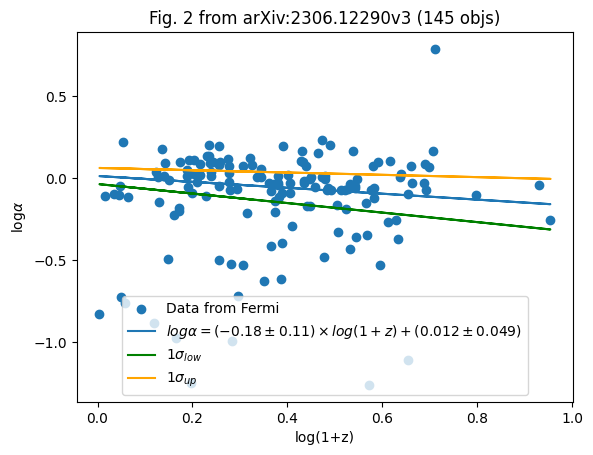

In [5]:
#plt.scatter(redshift_log,grb_table_alpha['Alpha'],color='red')
plt.scatter(redshift_log,alpha_log,label='Data from Fermi')
plt.plot(redshift_log,alpha_log_eq,label=r'$log\alpha = (−0.18 \pm 0.11) \times log(1 + z) + (0.012 \pm 0.049)$') 
plt.plot(redshift_log,alpha_log_eq_min,color='green',label=r'$1\sigma_{low}$')
plt.plot(redshift_log,alpha_log_eq_max,color='orange',label=r'$1\sigma_{up}$')
plt.legend(loc='lower center')
plt.xlabel('log(1+z)')
plt.ylabel(r'log$\alpha$')
plt.title("Fig. 2 from arXiv:2306.12290v3 (145 objs)")

# Approximation

Polynomial function is   
0.1434 x - 0.1716


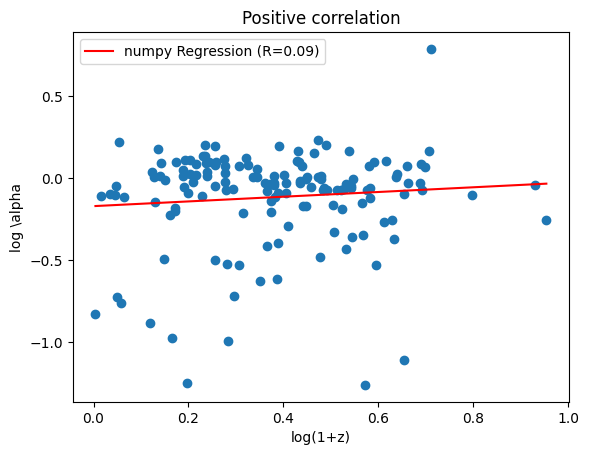

In [109]:
poly = np.poly1d(np.polyfit(redshift_log, alpha_log, 1))
redshift_linspace = np.linspace(redshift_log.min(),redshift_log.max(),len(redshift_log))
print("Polynomial function is ", poly)
alpha_poly = poly(redshift_linspace)
r_value = stat.linregress(redshift_log,alpha_log).rvalue
# Determine the correlation type
if 0 < r_value < 1:
    correlation_type = "Positive correlation"
elif -1 < r_value < 0:
    correlation_type = "Negative correlation"
elif r_value == 0:
    correlation_type = "No correlation"
elif r_value == 1 or r_value == -1:
    correlation_type = "Perfect correlation"
else:
    correlation_type = "Something went wrong..."

plt.scatter(redshift_log,alpha_log)
plt.plot(redshift_linspace,alpha_poly, label=f'numpy Regression (R={r_value:.2f})', color='red')
plt.title(correlation_type)
plt.legend()
plt.xlabel('log(1+z)')
plt.ylabel(r'log \alpha')
plt.show()

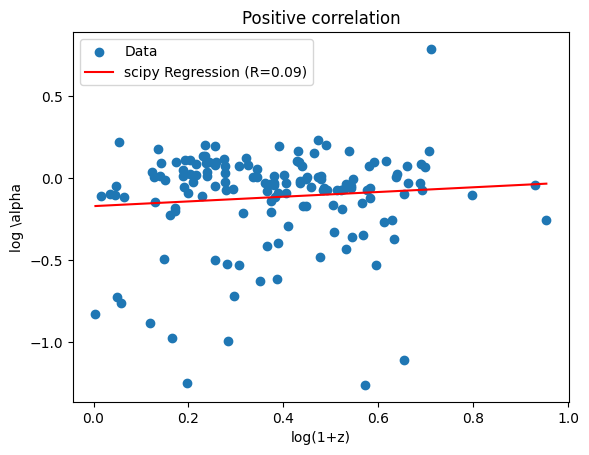

Positive correlation


In [72]:

from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(redshift_log, alpha_log)

# Create a linear regression line
redshift_linspace = np.linspace(redshift_log.min(), redshift_log.max(), 100)
alpha_poly = slope * redshift_linspace + intercept

# Plot the data and the linear regression line
plt.scatter(redshift_log, alpha_log, label='Data')
plt.plot(redshift_linspace, alpha_poly, label=f'scipy Regression (R={r_value:.2f})', color='red')

# Determine the correlation type
if 0 < r_value < 1:
    correlation_type = "Positive correlation"
elif -1 < r_value < 0:
    correlation_type = "Negative correlation"
elif r_value == 0:
    correlation_type = "No correlation"
elif r_value == 1 or r_value == -1:
    correlation_type = "Perfect correlation"
else:
    correlation_type = "Something went wrong..."

plt.title(correlation_type)
plt.legend()
plt.xlabel('log(1+z)')
plt.ylabel(r'log \alpha')
plt.show()

print(correlation_type)


# ML

In [73]:
# Предполагается, что alphas и redshifts - это списки или массивы NumPy
alphas = np.array(alpha_log).reshape(-1, 1)  # Преобразование в 2D массив для scikit-learn

# Разделение данных на обучающую и тестовую выборки
alphas_train, alphas_test, redshifts_train, redshifts_test = train_test_split(alphas, redshifts, test_size=0.4, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(alphas_train, redshifts_train)

# Предсказание на тестовых данных
redshifts_pred = model.predict(alphas_test)

# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(redshifts_test, redshifts_pred)
print(f'Mean Squared Error: {mse}')

# Вывод коэффициентов модели
print(f'Intercept: {model.intercept_}')
print(f'Slope: {model.coef_[0]}')

Mean Squared Error: 0.034863006662932614
Intercept: 0.3918766841637356
Slope: 0.03159325830400845


Среднеквадратичная ошибка (MSE): СКО измеряет, насколько "неправильными" являются прогнозы модели, усредняя квадраты различий между предсказанными и фактическими значениями.

Перехват (Intercept): Перехват - это точка, с которой линия регрессии начинается на вертикальной оси, представляя базовое значение, когда входное значение равно нулю.

Наклон (Slope): Наклон определяет крутизну линии регрессии и показывает, насколько зависимая переменная изменяется для каждого изменения независимой переменной на одну единицу.

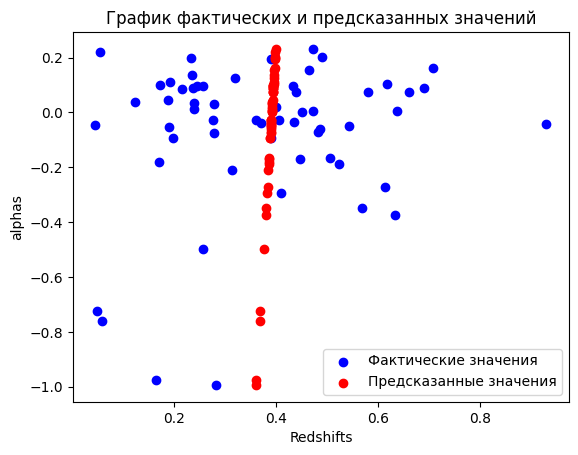

In [74]:
# Визуализация фактических и предсказанных значений
plt.scatter(redshifts_test, alphas_test, color='blue', label='Фактические значения')
plt.scatter(redshifts_pred, alphas_test, color='red', label='Предсказанные значения')
plt.xlabel('Redshifts')
plt.ylabel('alphas')
plt.legend()
plt.title('График фактических и предсказанных значений')
plt.show()

# Sampling

In [8]:
# Создайте условие для фильтрации
condition = (alpha_log > -0.69)

In [63]:
# Примените условие к обоим массивам
redshifts_80 = redshifts[condition]
alphas_80 = alpha_log[condition]
alphas_80 = np.array([round(a,3) for a in alphas_80])

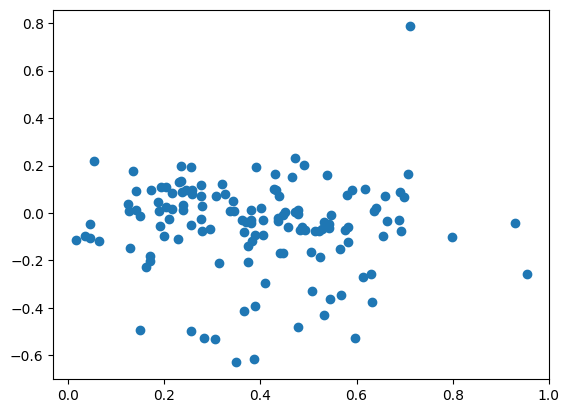

In [64]:
plt.scatter(redshifts_80, alphas_80)

In [65]:
df = pd.DataFrame({'redshifts_80': redshifts_80, 'alphas_80': alphas_80})

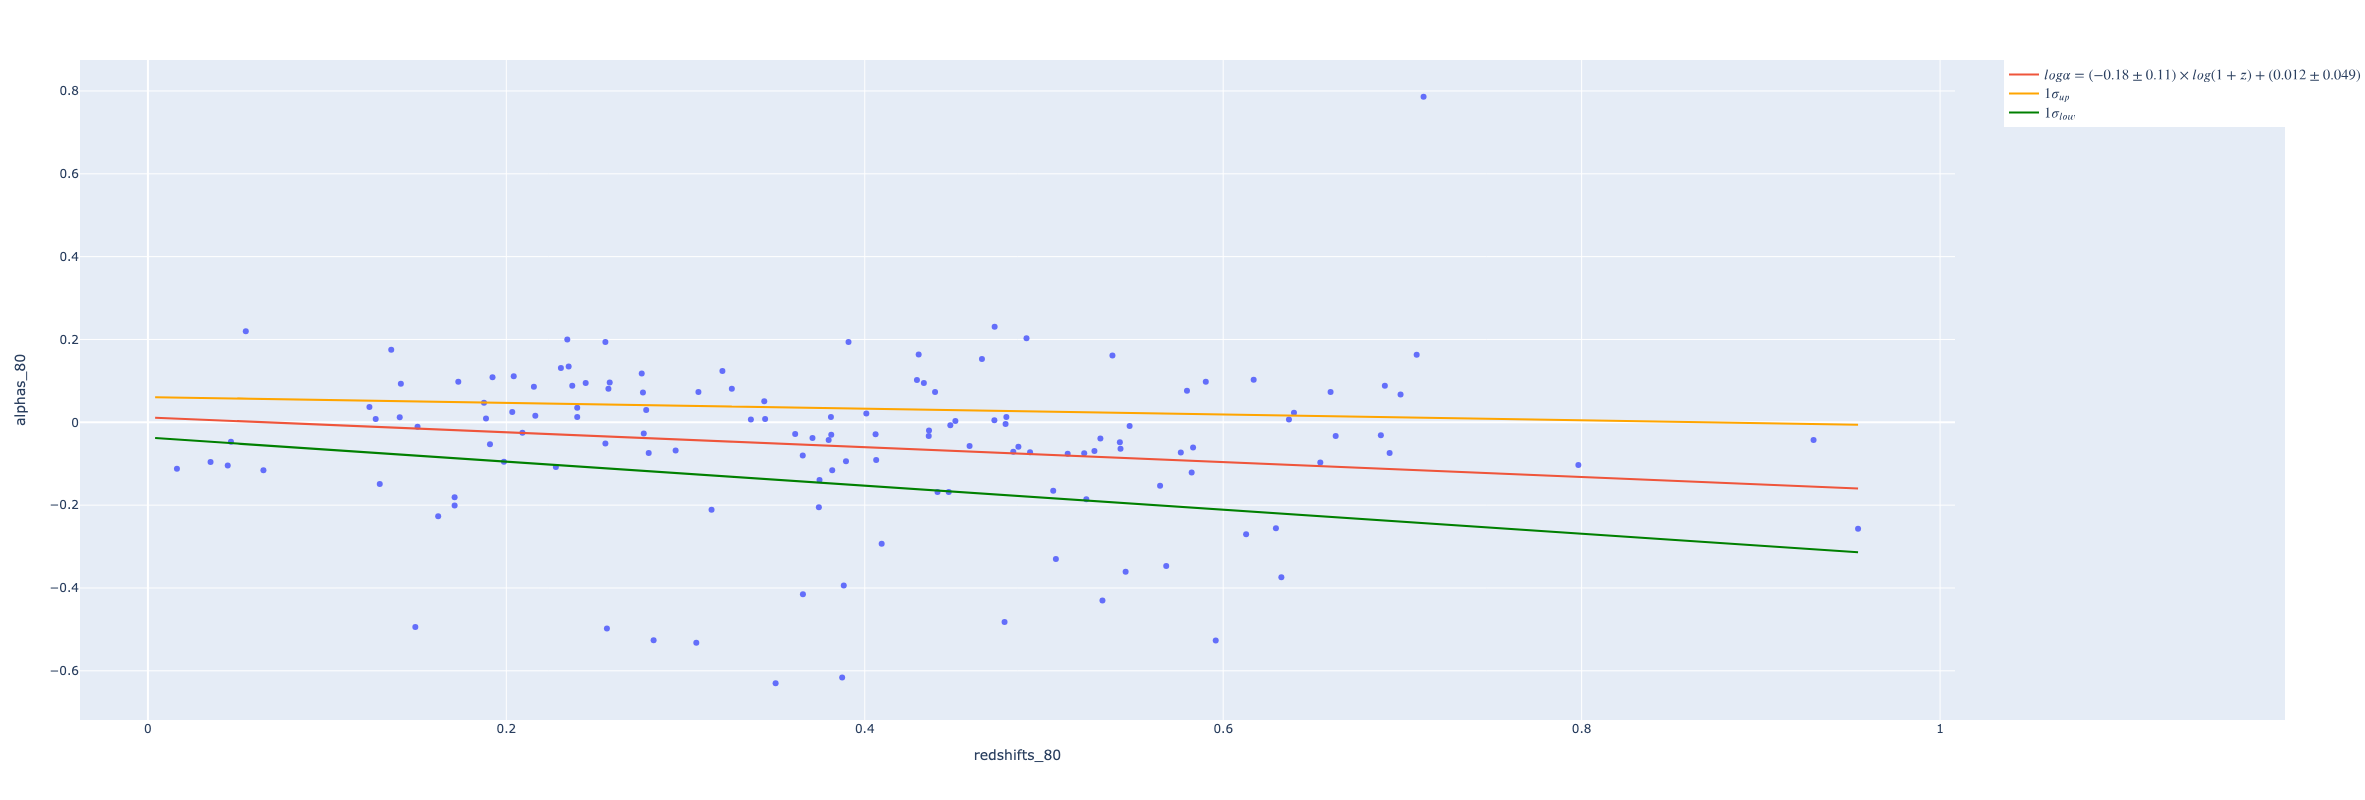

In [66]:
# Создаем scatterplot
fig = px.scatter(df, x='redshifts_80', y='alphas_80')

# Устанавливаем имя для scatterplot
fig.update_traces(name='Fermi data')

# Добавляем линии к scatter plot
fig.add_trace(go.Scatter(x=redshift_log, y=alpha_log_eq, mode='lines', name=r'$log\alpha = (−0.18 \pm 0.11) \times log(1 + z) + (0.012 \pm 0.049)$'))
fig.add_trace(go.Scatter(x=redshift_log, y=alpha_log_eq_max, mode='lines', name=r'$1\sigma_{up}$', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=redshift_log, y=alpha_log_eq_min, mode='lines', name=r'$1\sigma_{low}$', line=dict(color='green')))


# Установка высоты графика
fig.update_layout(height=800, width=1400)  # Здесь 400 - это высота в пикселях, которую вы можете изменить на нужное значение


# Отобразим график
fig.show()


In [74]:
alpha_del = [-0.532, -0.494, -0.112, -0.963, -0.104, -0.116, -0.149, -0.181,
       -0.201, -0.227, -0.047, -0.095, -0.068, -0.051, -0.116, -0.139,
       -0.08 , -0.186, -0.121, -0.043, -0.031,  0.007, -0.048, -0.069,
       -0.004,  0.003, -0.007, -0.029, -0.038,  0.008, -0.011,  0.012,
        0.09 ,  0.067,  0.076,  0.161,  0.203,  0.231,  0.153,  0.164,
        0.102,  0.095,  0.073,  0.124,  0.088,  0.118,  0.072,  0.135,
        0.131,  0.111,  0.22 ]

In [76]:
# Количество знаков после запятой, с которыми будем сравнивать
precision = 3

# Создаем новые пустые списки
redshift_log_filtered = []
alpha_log_filtered = []

# Проходим по значениям в исходных данных и проверяем их на соответствие
for redshift, alpha in zip(redshifts_80, alphas_80):
    rounded_alpha = round(alpha, precision)
    
    if rounded_alpha not in alpha_del:
        redshift_log_filtered.append(redshift)
        alpha_log_filtered.append(alpha)

# В результате получаем отфильтрованные списки
print("Отфильтрованный redshift_log:", len(redshift_log_filtered))
print("Отфильтрованный alpha_log:", len(alpha_log_filtered))
redshift_log_filtered = np.array(redshift_log_filtered)
alpha_log_filtered = np.array(alpha_log_filtered)


df = pd.DataFrame({'redshift_log_filtered': redshift_log_filtered, 'alpha_log_filtered': alpha_log_filtered})

Отфильтрованный redshift_log: 79
Отфильтрованный alpha_log: 79


### Approximation

Polynomial function is   
-0.1764 x - 0.01288


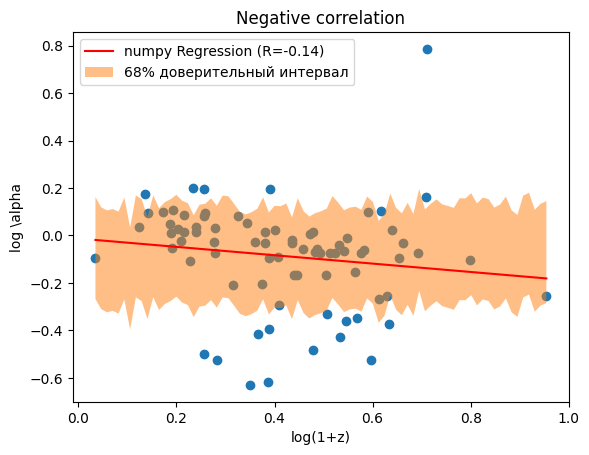

In [126]:
poly = np.poly1d(np.polyfit(redshift_log_filtered, alpha_log_filtered, 1))

redshift_linspace = np.linspace(redshift_log_filtered.min(),redshift_log_filtered.max(),len(redshift_log_filtered))
print("Polynomial function is ", poly)
alpha_poly = poly(redshift_linspace)
r_value = stat.linregress(redshift_log_filtered,alpha_log_filtered).rvalue

# Выполняем аппроксимацию полиномом первого порядка (линейная регрессия)
coefficients = np.polyfit(redshift_log_filtered, alpha_log_filtered, 1)
poly = np.poly1d(coefficients)

# Вычисляем стандартную ошибку оценки коэффициентов
residuals = alpha_log_filtered - poly(redshift_log_filtered)
std_error = np.std(residuals)

# Задаем уровень доверия (например, 1 сигма - примерно 68%)
confidence_level = 0.68

# Вычисляем границы доверительного интервала
lower_bound = poly(redshift_log_filtered) - std_error
upper_bound = poly(redshift_log_filtered) + std_error

# Determine the correlation type
if 0 < r_value < 1:
    correlation_type = "Positive correlation"
elif -1 < r_value < 0:
    correlation_type = "Negative correlation"
elif r_value == 0:
    correlation_type = "No correlation"
elif r_value == 1 or r_value == -1:
    correlation_type = "Perfect correlation"
else:
    correlation_type = "Something went wrong..."

plt.scatter(redshift_log_filtered,alpha_log_filtered)
plt.plot(redshift_linspace,alpha_poly, label=f'numpy Regression (R={r_value:.2f})', color='red')
plt.fill_between(redshift_linspace, lower_bound, upper_bound, alpha=0.5, label=f"{int(confidence_level*100)}% доверительный интервал")
plt.title(correlation_type)
plt.legend()
plt.xlabel('log(1+z)')
plt.ylabel(r'log \alpha')
plt.show() 

### ML

Model: Linear Regression
Optimal Parameters: {}
Mean Squared Error (MSE): 0.0309
R-squared: 0.0209


Model: Lasso
Optimal Parameters: {'alpha': 0.01}
Mean Squared Error (MSE): 0.0316
R-squared: 0.0000


Model: Ridge
Optimal Parameters: {'alpha': 10.0}
Mean Squared Error (MSE): 0.0313
R-squared: 0.0098


Model: ElasticNet
Optimal Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Mean Squared Error (MSE): 0.0316
R-squared: 0.0000




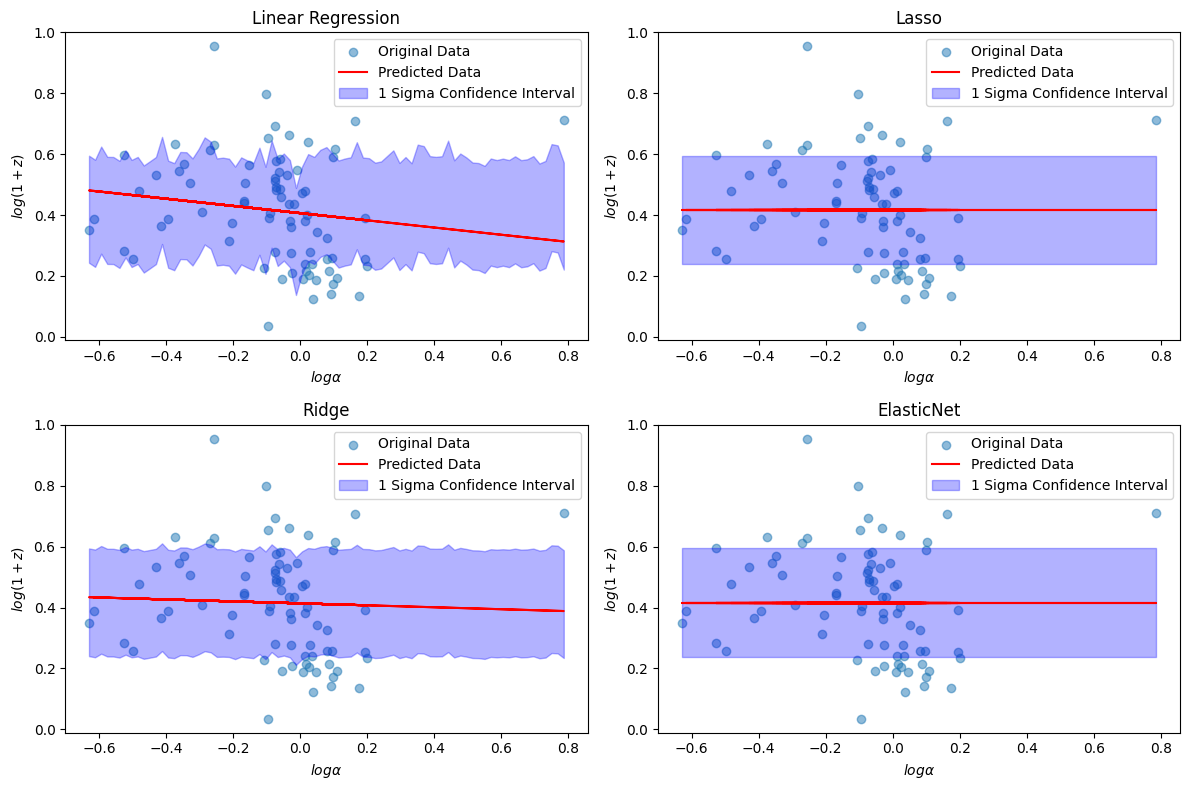

In [183]:
# Создаем данные (предполагая, что x и y - это ваши данные)
x,y =  alpha_log_filtered, redshift_log_filtered
alpha_linspace = np.linspace(alpha_log_filtered.min(),alpha_log_filtered.max(),len(alpha_log_filtered))
# Создаем модели
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# Определяем параметры для каждой модели
param_grids = {
    'Linear Regression': {},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
}

# Создаем subplot для графиков
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models.items()):
    # Определяем сетку параметров для поиска
    param_grid = param_grids[model_name]
    
    # Создаем объект GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Выполняем поиск по сетке
    grid_search.fit(x.reshape(-1, 1), y)
    
    # Получаем оптимальные значения параметров
    best_params = grid_search.best_params_
    
    # Создаем и обучаем модель с оптимальными параметрами
    optimal_model = model.set_params(**best_params)
    optimal_model.fit(x.reshape(-1, 1), y)
    
    # Вычисляем предсказания
    y_pred_optimal = optimal_model.predict(x.reshape(-1, 1))
    
    # Вычисляем MSE и R-squared
    mse = mean_squared_error(y, y_pred_optimal)
    r_squared = r2_score(y, y_pred_optimal)
    
    # Вычисляем доверительный интервал (1 сигма)
    std_error = np.std(y - y_pred_optimal)
    lower_bound = y_pred_optimal - std_error
    upper_bound = y_pred_optimal + std_error
    
    # Выводим графики
    axes[idx].scatter(x, y, label='Original Data', alpha=0.5)
    axes[idx].plot(x, y_pred_optimal, color='red', label='Predicted Data')
    axes[idx].fill_between(alpha_linspace, lower_bound, upper_bound, alpha=0.3, label='1 Sigma Confidence Interval', color='blue')
    axes[idx].set_title(model_name)
    axes[idx].set_xlabel(r'$log \alpha$')
    axes[idx].set_ylabel(r'$log(1+z)$')
    axes[idx].legend()
    
    # Выводим параметры, MSE и R-squared
    print(f'Model: {model_name}')
    print(f'Optimal Parameters: {best_params}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'R-squared: {r_squared:.4f}')
    print('\n')

plt.tight_layout()
plt.show()
fig.savefig('ml_linear_alpha_z.png')